In [2]:
import pandas as pd
import pod5 as p5

def load_data(tsv_file, pod_file):
    polyA_df = pd.read_csv(tsv_file, sep='\t', skiprows=1, skipfooter=3, engine='python')
    polyA_df.columns = polyA_df.columns.str.strip()

    with p5.Reader(pod_file) as reader:
        pod_data = {str(read.read_id): read.signal for read in reader.reads()}

    polyA_df['signal'] = polyA_df['read_id'].map(pod_data)

    polyA_df.dropna(subset=['signal'], inplace=True)

    return polyA_df

In [73]:
df = load_data("egfp_a120_1mod_polyA_position.tsv", "egfp_a120_1mod_polya_reads.pod5")

In [42]:
import numpy as np 

def remove_outliers(signal, threshold, index=None):
    original_length = len(signal)
    mean = np.mean(signal)
    std = np.std(signal)
    if std == 0:
        return signal
    z_scores = np.abs((signal - mean) / std)
    filtered = signal[z_scores < threshold]
    filtered_length = len(filtered)
    if filtered_length < original_length and index is not None:
        print(f"Række {index}: signal længde før: {original_length}, efter outlier-fjernelse: {filtered_length}")
    return filtered

In [74]:
import matplotlib.pyplot as plt

def remove_outliers(signal, threshold, index=None, return_mask=False, original_start=0):
    original_length = len(signal)
    mean = np.mean(signal)
    std = np.std(signal)
    
    if std == 0:
        if index is not None:
            print(f"Række {index}: Standardafvigelsen er 0, ingen outliers kan fjernes.")
        return signal if not return_mask else (signal, np.full(len(signal), True))

    z_scores = np.abs((signal - mean) / std)
    mask = z_scores < threshold
    filtered_signal = signal[mask]

    removed_count = np.sum(~mask)
    filtered_length = len(filtered_signal)

    # Juster indekserne for at matche originalens indekser
    removed_indices = np.where(~mask)[0] + original_start

    if index is not None:
        print(f"Række {index}: Længde før = {original_length}, efter = {filtered_length}, fjernet = {removed_count} ({(removed_count/original_length)*100:.2f}%)")
        if removed_count > 0:
            print(f"Fjernede indekser: {removed_indices}")

    return filtered_signal if not return_mask else (filtered_signal, mask)

def vectorize_and_plot(row, vector_length, window_size_avg, window_size_var, threshold, index=None):
    read_id = row['read_id']
    raw_signal = row['signal']
    start = row['start']
    end = row['end']

    # Tag kun signalet mellem start og end
    signal = raw_signal[start:end]

    # Plot raw signal kun mellem start og end
    plt.figure(figsize=(12, 4))
    plt.plot(range(start, end), signal, color='blue', alpha=0.7)
    plt.title(f"Raw signal - Read {read_id}")
    plt.xlabel("Sample Index")
    plt.ylabel("Current (pA)")
    plt.grid(True)
    plt.show()

    # Fjern outliers kun fra signalet mellem start og end
    signal = remove_outliers(signal, threshold, index=index, original_start=start)

    # Normaliser baseret på 25–75% segment
    first_quantile = int(0.25 * len(signal))
    third_quantile = int(0.75 * len(signal))
    signal50 = signal[first_quantile:third_quantile]
    
    if len(signal50) == 0:
        print("Ingen signaldata i 25–75% området.")
        return

    signal50_mean = np.mean(signal50)
    if signal50_mean == 0:
        print("Mean af 25–75% region er nul.")
        return

    normalized = signal / signal50_mean

    means = []
    variations = []

    for j in range(vector_length):
        x = j * (len(signal) / vector_length)
        x = int(x)

        start_index_avg = max(int(x - (window_size_avg // 2)), 0)
        end_index_avg = min(int(x + (window_size_avg // 2)), len(normalized))
        window_avg = normalized[start_index_avg:end_index_avg]
        means.append(np.mean(window_avg) if len(window_avg) > 0 else np.nan)

        start_index_var = max(int(x - (window_size_var // 2)), 0)
        end_index_var = min(int(x + (window_size_var // 2)), len(normalized))
        window_var = normalized[start_index_var:end_index_var]
        variations.append(np.var(window_var) if len(window_var) > 0 else np.nan)

    x_vals = np.arange(vector_length)

    # Plot Mean
    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, means, label='Mean', color='blue')
    plt.title(f"Mean - Read {read_id}")
    plt.xlabel("Window Index")
    plt.ylabel("Normalized Mean")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Variation
    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, variations, label='Variation', color='orange')
    plt.title(f"Variation - Read {read_id}")
    plt.xlabel("Window Index")
    plt.ylabel("Variance")
    plt.legend()
    plt.grid(True)
    plt.show()


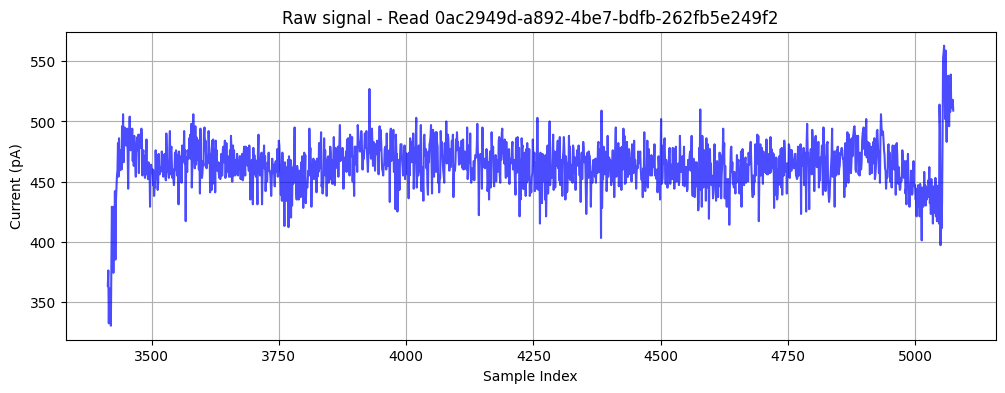

Række 0: Længde før = 1662, efter = 1655, fjernet = 7 (0.42%)
Fjernede indekser: [3414 3416 3417 3418 3419 3420 5057]


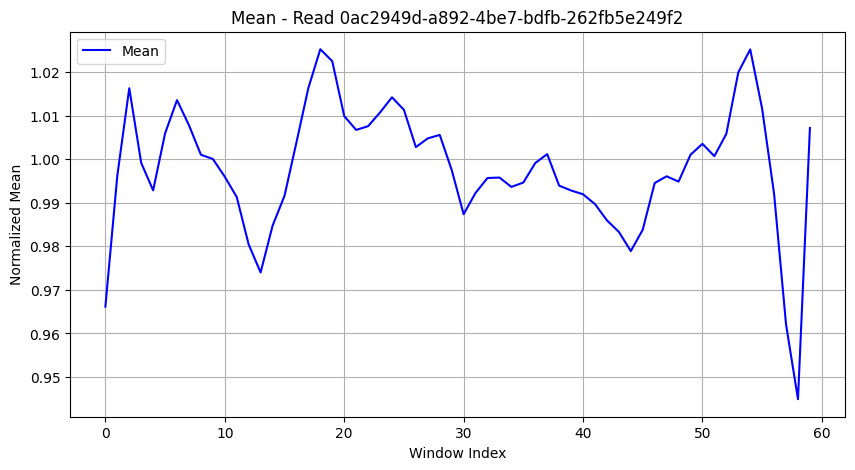

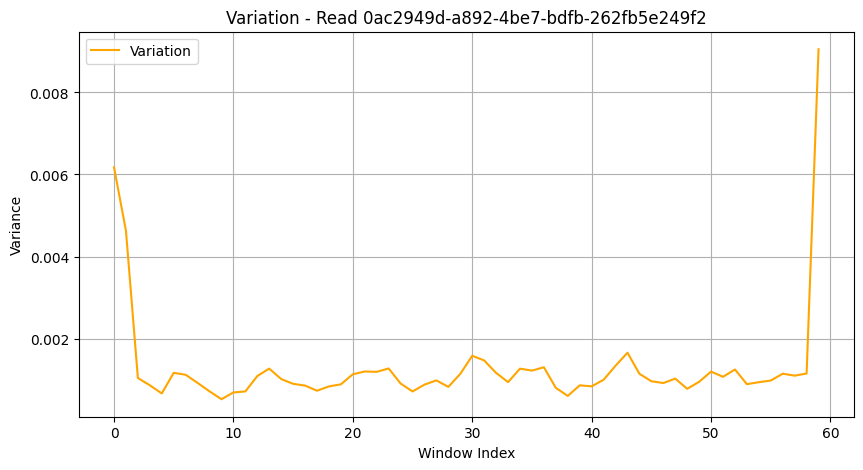

In [103]:
vectorize_and_plot(df.iloc[22], vector_length=60, window_size_avg=60, window_size_var=60, threshold=5, index=0)